In [461]:
import numpy as np 
import pandas as pd 

In [462]:
df = pd.read_csv('./spam.csv',encoding = "ISO-8859-1")
df.shape

(5572, 5)

Project will be in 8 stages 
1. Data Cleaning
2. EDA
3. Text preprocessing
4. Model building
5. Evaluation 
6. Improvements
7. Website
8. Deployment

<h1>Data Cleaning<h1>

In [463]:
# Data Cleaning
df.info

#drop last 3 columns
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'], inplace=True)
df.sample(5)

# renaming the columns
df.rename(columns={'v1': 'target', 'v2':'text'},inplace=True)
df.sample(5)

,target,text
2343,ham,1) Go to write msg 2) Put on Dictionary mode 3...
4424,ham,Just now saw your message.it k da:)
3186,ham,Howz that persons story
1485,ham,(I should add that I don't really care and if ...
1515,ham,I wonder if you'll get this text?


In [464]:
#encoding data into numerical values
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])

In [465]:
#missing values 
df.isnull().sum()

#removing duplicates
df = df.drop_duplicates(keep='first')
df.duplicated().sum()

0

<h1>Exploratory Data Analysis (EDA)<h2>

In [466]:
#check how many messages are spam or ham
df['target'].value_counts()

0    4516
1     653
Name: target, dtype: int64

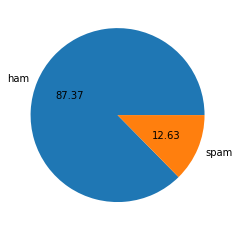

In [467]:
import matplotlib.pyplot as plt 

plt.pie(df['target'].value_counts(), labels=['ham','spam'], autopct="%0.2f")
plt.show()

In [468]:
# data is imbalaced so doing deep data analysis
import nltk
#nltk.download('punkt')
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer

#for deep analysis we will make 3 new columns: 
#No of characters in email
#No of words in email
#No of sentences in email

In [469]:
df['num_characters'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df['num_sentences'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))


In [470]:

#describing the data
df[['num_characters', 'num_words', 'num_sentences']].describe()
#for ham
df[df['target'] == 0][['num_characters', 'num_words', 'num_sentences']].describe()
#for spam
df[df['target'] == 1][['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.967841
std,30.137753,7.008418,1.483201
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,8.000000


<AxesSubplot:xlabel='num_characters', ylabel='Count'>

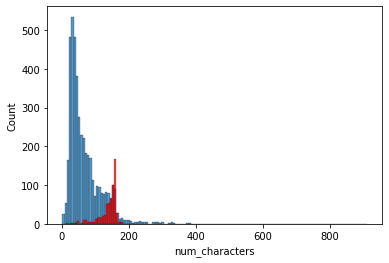

In [471]:
import seaborn as sns 
#extract all ham
sns.histplot(df[df['target'] == 0]['num_characters'])
sns.histplot(df[df['target'] == 1]['num_characters'], color='red')


<AxesSubplot:xlabel='num_words', ylabel='Count'>

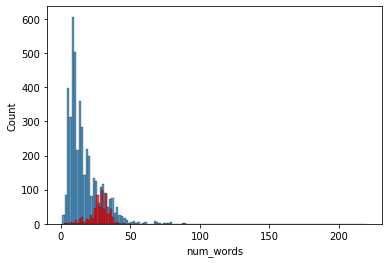

In [472]:
sns.histplot(df[df['target'] == 0]['num_words'])
sns.histplot(df[df['target'] == 1]['num_words'], color='red')

<AxesSubplot:xlabel='num_sentences', ylabel='Count'>

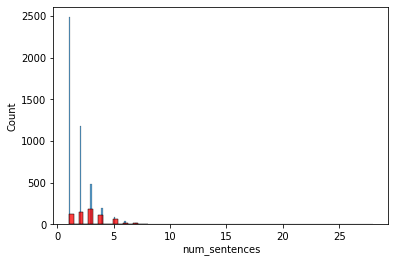

In [473]:
sns.histplot(df[df['target'] == 0]['num_sentences'])
sns.histplot(df[df['target'] == 1]['num_sentences'], color='red')

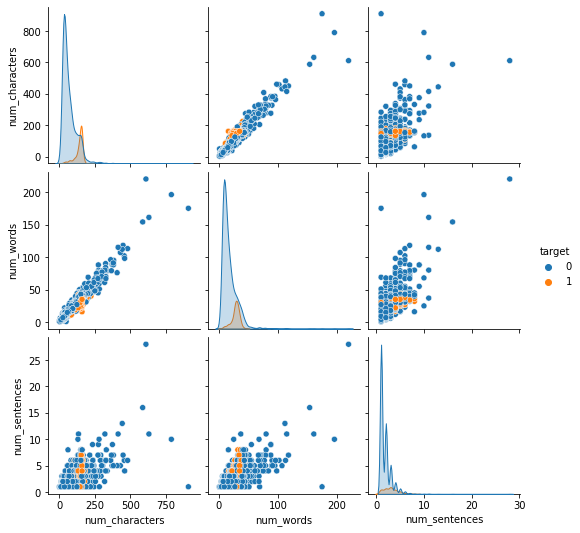

In [474]:
sns.pairplot(df,hue='target')

<AxesSubplot:>

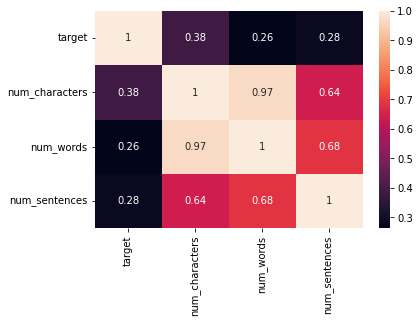

In [475]:
# check correlations
sns.heatmap(df.corr(),annot=True)

<h2>Data Preprocessing</h2>
 1. lower case
 2. Tokenization
 3. Removing special character
 4. Removing stop words and punctuations
 5. Stemming

In [476]:
 
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    y = []
    
    #removing special character
    for i in text: 
        if i.isalnum():
            y.append(i)
    
    #stopwords removal 
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
    
    #stemming
    ps = PorterStemmer()
    text = y[:]
    y.clear()
    
    for i in text: 
        y.append(ps.stem(i))        
                            
    return " ".join(y)   

In [477]:
df['transformed_text'] = df['text'].apply(transform_text ) 

In [478]:
# making word cloud 
from wordcloud import WordCloud

wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')


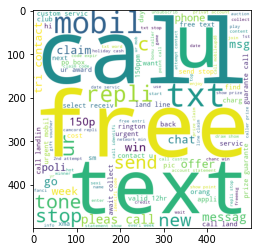

In [479]:
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))
plt.imshow(spam_wc)

In [480]:
# now we want top 30 or 50 words in ham or spam 
spam_corpus = []
for msg in df[df['target'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)


In [481]:
from collections import Counter
sns.barplot(pd.DataFrame(Counter(spam_corpus).most_common(30))[0],pd.DataFrame(Counter(spam_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.show()

TypeError: barplot() takes from 0 to 1 positional arguments but 2 were given

In [ ]:
ham_corpus = []
for msg in df[df['target'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)
